In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import nfl_data_py as nfl
import statsmodels.api as sm
import statsmodels.formula.api as smf 
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set_theme(style="whitegrid", palette="colorblind")

In [2]:
draft_py_use = pd.read_pickle("../datasets/filtered_nfl_draft_ch7_plays.pkl")

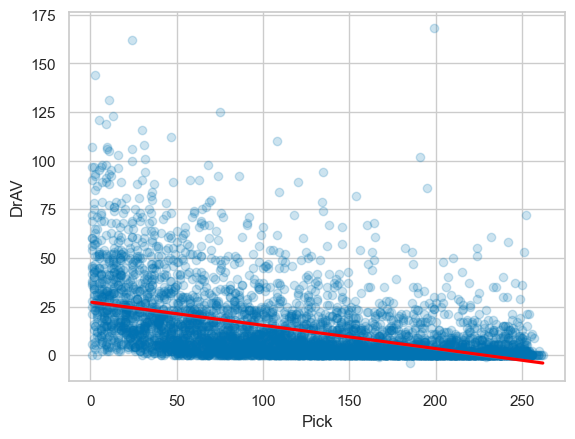

In [3]:
# ----------------------
# Data Analysis & Visualization
# ----------------------
# Filter for pre-2019 data
draft_py_use_pre2019 = draft_py_use.query("Season <= 2019")
draft_py_use_pre2019 = draft_py_use_pre2019.astype({"Pick": int, "DrAV": float})

# Set visual theme
sns.set_theme(style="whitegrid", palette="colorblind")

# Create regression plot
sns.regplot(data=draft_py_use_pre2019,
            x="Pick",
            y="DrAV",
            line_kws={"color": "red"},
            scatter_kws={'alpha': 0.2})
plt.show()


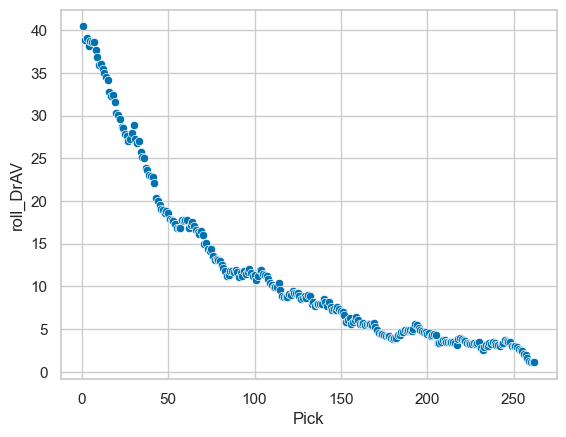

In [6]:
# Create draft value chart
draft_chart_py = (
    draft_py_use_pre2019
    .groupby(["Pick"])
    .agg({"DrAV": ["mean"]})
)

# Flatten MultiIndex column names
draft_chart_py.columns = ["DrAV_mean"]

# Handle missing values
draft_chart_py.loc[draft_chart_py["DrAV_mean"].isnull(), "DrAV_mean"] = 0

# Calculate rolling average
draft_chart_py["roll_DrAV"] = (
    draft_chart_py["DrAV_mean"]
    .rolling(window=13, min_periods=1, center=True)
    .mean()
)

# Plot rolling average
sns.scatterplot(data=draft_chart_py, x=draft_chart_py.index, y="roll_DrAV")
plt.show()


In [8]:
# ----------------------
# Statistical Modeling
# ----------------------
# Logarithmic transformation
draft_chart_py.reset_index(inplace=True)
draft_chart_py["roll_DrAV_log"] = np.log(draft_chart_py["roll_DrAV"] + 1)

# OLS Regression
DrAV_pick_fit_py = smf.ols(formula="roll_DrAV_log ~ Pick", 
                          data=draft_chart_py).fit()
print(DrAV_pick_fit_py.summary())


                            OLS Regression Results                            
Dep. Variable:          roll_DrAV_log   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     8373.
Date:                Tue, 01 Apr 2025   Prob (F-statistic):          8.78e-200
Time:                        11:45:43   Log-Likelihood:                 172.67
No. Observations:                 262   AIC:                            -341.3
Df Residuals:                     260   BIC:                            -334.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.5126      0.016    225.576      0.0

In [13]:
draft_chart_py["fitted_DrAV"] = np.exp(DrAV_pick_fit_py.predict()) - 1
draft_chart_py.head()

,Pick,DrAV_mean,roll_DrAV,roll_DrAV_log,fitted_DrAV
0,1,49.45,40.428571,3.723971,32.220973
1,2,40.80,38.825000,3.684495,31.910391
2,3,45.75,39.105556,3.691515,31.602712
3,4,32.60,38.190000,3.668422,31.297910
4,5,43.70,38.768182,3.683067,30.995958


In [14]:
# ----------------------
# Team Performance Analysis
# ----------------------
# Merge fitted values
draft_py_use_pre2019 = draft_py_use_pre2019.merge(
    draft_chart_py[["Pick", "fitted_DrAV"]], 
    on="Pick"
)

# Calculate over/under performance
draft_py_use_pre2019["OE"] = draft_py_use_pre2019["DrAV"] - draft_py_use_pre2019["fitted_DrAV"]

# Team aggregation
team_performance = (draft_py_use_pre2019
                   .groupby("Tm")
                   .agg(OE_count=("OE", "count"),
                        OE_mean=("OE", "mean"),
                        OE_std=("OE", "std"))
                   .reset_index()
                   .sort_values("OE_mean", ascending=False))

# Calculate confidence intervals
team_performance["se"] = team_performance["OE_std"] / np.sqrt(team_performance["OE_count"])
team_performance["lower_bound"] = team_performance["OE_mean"] - 1.96 * team_performance["se"]
team_performance["upper_bound"] = team_performance["OE_mean"] + 1.96 * team_performance["se"]

print(team_performance)

     Tm  OE_count   OE_mean     OE_std        se  lower_bound  upper_bound
26  PIT       161  3.561062  19.504137  1.537141     0.548265     6.573859
11  GNB       180  3.414117  20.110784  1.498969     0.476137     6.352097
8   DAL       160  2.676151  17.669999  1.396936    -0.061844     5.414145
1   ATL       148  2.331055  16.349847  1.343949    -0.303085     4.965196
21  NOR       131  2.250549  18.657268  1.630093    -0.944434     5.445531
13  IND       162  2.061769  16.254429  1.277069    -0.441285     4.564824
22  NWE       176  2.016079  20.866532  1.572874    -1.066754     5.098912
2   BAL       170  1.976069  17.790317  1.364455    -0.698263     4.650401
4   CAR       148  1.695588  16.499254  1.356230    -0.962624     4.353799
27  SEA       181  1.499759  17.275427  1.284072    -1.017022     4.016541
16  LAC       144  1.463305  14.871767  1.239314    -0.965751     3.892360
15  KAN       154  0.664439  16.331357  1.316018    -1.914956     3.243835
25  PHI       162  0.6397